# How to obtain barcodes that are likely cells

This document provides intruction on how to obtain barcodes for downstream analyses. This step generates a series of plots for quality control purpose. At the end of this document, there are intructions on how to set up a Snakemake file to obtain QC plots for all samples.

## Script and QC plot explanation 

Import packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tables
import anndata
from typing import Dict, Optional
import numpy as np
import scipy.sparse as sp
from scipy import io
import glob
import os
import upsetplot
from scipy.io import mmread
import csv

/tmp/ipykernel_1213923/1763992921.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Set up multiple helper functions:

In [2]:
#### FUNCTIONS FROM CELLBENDER
def dict_from_h5(file: str) -> Dict[str, np.ndarray]:
    """Read in everything from an h5 file and put into a dictionary."""
    d = {}
    with tables.open_file(file) as f:
        # read in everything
        for array in f.walk_nodes("/", "Array"):
            d[array.name] = array.read()
    return d


def anndata_from_h5(file: str,
                    analyzed_barcodes_only: bool = True) -> 'anndata.AnnData':
    """Load an output h5 file into an AnnData object for downstream work.
    Args:
        file: The h5 file
        analyzed_barcodes_only: False to load all barcodes, so that the size of
            the AnnData object will match the size of the input raw count matrix.
            True to load a limited set of barcodes: only those analyzed by the
            algorithm. This allows relevant latent variables to be loaded
            properly into adata.obs and adata.obsm, rather than adata.uns.
    Returns:
        adata: The anndata object, populated with inferred latent variables
            and metadata.
    """

    d = dict_from_h5(file)
    X = sp.csc_matrix((d.pop('data'), d.pop('indices'), d.pop('indptr')),
                      shape=d.pop('shape')).transpose().tocsr()

    # check and see if we have barcode index annotations, and if the file is filtered
    barcode_key = [k for k in d.keys() if (('barcode' in k) and ('ind' in k))]
    if len(barcode_key) > 0:
        max_barcode_ind = d[barcode_key[0]].max()
        filtered_file = (max_barcode_ind >= X.shape[0])
    else:
        filtered_file = True

    if analyzed_barcodes_only:
        if filtered_file:
            # filtered file being read, so we don't need to subset
            print('Assuming we are loading a "filtered" file that contains only cells.')
            pass
        elif 'barcode_indices_for_latents' in d.keys():
            X = X[d['barcode_indices_for_latents'], :]
            d['barcodes'] = d['barcodes'][d['barcode_indices_for_latents']]
        elif 'barcodes_analyzed_inds' in d.keys():
            X = X[d['barcodes_analyzed_inds'], :]
            d['barcodes'] = d['barcodes'][d['barcodes_analyzed_inds']]
        else:
            print('Warning: analyzed_barcodes_only=True, but the key '
                  '"barcodes_analyzed_inds" or "barcode_indices_for_latents" '
                  'is missing from the h5 file. '
                  'Will output all barcodes, and proceed as if '
                  'analyzed_barcodes_only=False')

    # Construct the anndata object.
    adata = anndata.AnnData(X=X,
                            obs={'barcode': d.pop('barcodes').astype(str)},
                            var={'gene_name': (d.pop('gene_names') if 'gene_names' in d.keys()
                                               else d.pop('name')).astype(str)},
                            dtype=X.dtype)
    adata.obs.set_index('barcode', inplace=True)
    adata.var.set_index('gene_name', inplace=True)

    # For CellRanger v2 legacy format, "gene_ids" was called "genes"... rename this
    if 'genes' in d.keys():
        d['id'] = d.pop('genes')

    # For purely aesthetic purposes, rename "id" to "gene_id"
    if 'id' in d.keys():
        d['gene_id'] = d.pop('id')

    # If genomes are empty, try to guess them based on gene_id
    if 'genome' in d.keys():
        if np.array([s.decode() == '' for s in d['genome']]).all():
            if '_' in d['gene_id'][0].decode():
                print('Genome field blank, so attempting to guess genomes based on gene_id prefixes')
                d['genome'] = np.array([s.decode().split('_')[0] for s in d['gene_id']], dtype=str)

    # Add other information to the anndata object in the appropriate slot.
    _fill_adata_slots_automatically(adata, d)

    # Add a special additional field to .var if it exists.
    if 'features_analyzed_inds' in adata.uns.keys():
        adata.var['cellbender_analyzed'] = [True if (i in adata.uns['features_analyzed_inds'])
                                            else False for i in range(adata.shape[1])]

    if analyzed_barcodes_only:
        for col in adata.obs.columns[adata.obs.columns.str.startswith('barcodes_analyzed')
                                     | adata.obs.columns.str.startswith('barcode_indices')]:
            try:
                del adata.obs[col]
            except Exception:
                pass
    else:
        # Add a special additional field to .obs if all barcodes are included.
        if 'barcodes_analyzed_inds' in adata.uns.keys():
            adata.obs['cellbender_analyzed'] = [True if (i in adata.uns['barcodes_analyzed_inds'])
                                                else False for i in range(adata.shape[0])]

    return adata


def _fill_adata_slots_automatically(adata, d):
    """Add other information to the adata object in the appropriate slot."""

    # TODO: what about "features_analyzed_inds"?  If not all features are analyzed, does this work?

    for key, value in d.items():
        try:
            if value is None:
                continue
            value = np.asarray(value)
            if len(value.shape) == 0:
                adata.uns[key] = value
            elif value.shape[0] == adata.shape[0]:
                if (len(value.shape) < 2) or (value.shape[1] < 2):
                    adata.obs[key] = value
                else:
                    adata.obsm[key] = value
            elif value.shape[0] == adata.shape[1]:
                if value.dtype.name.startswith('bytes'):
                    adata.var[key] = value.astype(str)
                else:
                    adata.var[key] = value
            else:
                adata.uns[key] = value
        except Exception:
            print('Unable to load data into AnnData: ', key, value, type(value))


#### END FUNCTIONS FROM CELLBENDER
            
def cellbender_anndata_to_cell_probability(a):
    return a.obs.cell_probability


def cellbender_anndata_to_sparse_matrix(adata, min_cell_probability=0):
    barcodes = adata.obs[adata.obs.cell_probability>=min_cell_probability].index.to_list()
    features = adata.var.gene_id.to_list()
    matrix = adata[adata.obs.cell_probability>=min_cell_probability].X.transpose()
    return {'features': features, 'barcodes': barcodes, 'matrix': matrix}


def umi_count_after_decontamination(adata):
    x = cellbender_anndata_to_sparse_matrix(adata)
    return dict(zip(x['barcodes'], x['matrix'].sum(axis=0).tolist()[0]))


def barcode_rank_plot(metrics, ax):
    df = metrics.sort_values('rna_umis', ascending=False)
    df['barcode_rank'] = range(1, len(df) + 1)
    sns.scatterplot(x='barcode_rank', y='rna_umis', data=df, ax=ax, hue='pass_all_filters', palette={True: 'red', False: 'black'}, edgecolor=None, alpha=0.2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Barcode rank')
    ax.set_ylabel('UMIs')
    return ax


def rna_umis_vs_rna_mito_plot(metrics, ax):
    sns.scatterplot(x='rna_umis', y='rna_fraction_mitochondrial', data=metrics, ax=ax, hue='pass_all_filters', palette={True: 'red', False: 'black'}, edgecolor=None, alpha=0.02, s=3)
    ax.set_xscale('log')
    ax.set_xlabel('UMIs')
    ax.set_ylabel('Fraction mito. (RNA)')
    return ax

def cellbender_fraction_removed(metrics, ax):
    sns.scatterplot(x='rna_umis', y='fraction_cellbender_removed', data=metrics, ax=ax, hue='pass_all_filters', palette={True: 'red', False: 'black'}, edgecolor=None, alpha=0.05)
    ax.set_xscale('log')
    ax.set_xlabel('UMIs')
    ax.set_ylabel('Fraction ambient')
    return ax


def cellbender_cell_probabilities(metrics, ax):
    sns.histplot(x='cell_probability', data=metrics[(metrics.filter_rna_emptyDrops) & (metrics.filter_rna_max_mito)], ax=ax, bins=20)
    ax.set_xlabel('Cellbender cell prob.\nfor cells by EmptyDrops and mito. thresholds')
    return ax

### FUNCTION TO RUN MULTI-OTSU THRESHOLDING
from skimage.filters import threshold_multiotsu
def estimate_threshold(x, classes=3):
    # do on logscale
    values = np.log10(x).values
    values = values.reshape((len(values),1))
    thresholds = threshold_multiotsu(image=values, classes=classes, nbins=256)
    # convert back to linear scale
    thresholds = [pow(10, i) for i in thresholds]
    UMI_THRESHOLD = round(thresholds[classes - 2])
    return UMI_THRESHOLD

Set up input files:

In [3]:
dir = "/nfs/turbo/umms-scjp-pank/1_HPAP/results/rna/gencode_v39" #change dir to where QC data is stored
donor = "HPAP-020" #change to which donor's data is being processed

with open('/nfs/turbo/umms-scjp-pank/1_HPAP/metadata/PancDB_scRNA-seq_metadata_10x.txt', 'r') as file: #obtain metadata
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        if row[0] == donor:
            metadata = row
            
CELLBENDER = dir + '/cellbender/cellbender_default/' + donor + '-hg38.cellbender_FPR_0.05.h5'
RNA_METRICS = dir + '/qc/' + donor + '-hg38.qc.txt'
PASS_QC = dir + "/emptyDrops/results/" + donor + "_pass.txt"
KNEE_FILE  = dir + "/emptyDrops/results/" + donor + "_knee.txt"

if metadata[6] == '10X-Chromium-GEX-3p-v2':
    RNA_BARCODE_WHITELIST = "/nfs/turbo/umms-scjp-pank/1_HPAP/scripts/snRNAseq-NextFlow_v2/737K-august-2016.txt"
else:
    RNA_BARCODE_WHITELIST = "/nfs/turbo/umms-scjp-pank/1_HPAP/scripts/snRNAseq-NextFlow_v3/3M-february-2018.txt"

GENE_FULL_EXON_OVER_INTRON_COUNTS = dir + '/starsolo/' + donor + '-hg38/' + donor + '-hg38.Solo.out/GeneFull_ExonOverIntron/raw'
GENE_COUNTS = dir + '/starsolo/' + donor + '-hg38/' + donor + '-hg38.Solo.out/Gene/raw/'

Load input files:

In [4]:
rna_barcodes = pd.read_csv(RNA_BARCODE_WHITELIST, header=None)[0].to_list()
adata = anndata_from_h5(CELLBENDER, analyzed_barcodes_only=True)
rna_metrics = pd.read_csv(RNA_METRICS, sep='\t')
rna_metrics = rna_metrics[rna_metrics.barcode!='-']

metrics = rna_metrics.set_index('barcode').rename(columns=lambda x: 'rna_' + x)

metrics = metrics.reset_index()
cell_probability = cellbender_anndata_to_cell_probability(adata)
post_cellbender_umis = umi_count_after_decontamination(adata)

metrics['cell_probability'] = metrics.barcode.map(lambda x: cell_probability[x] if x in cell_probability else np.nan)
metrics['post_cellbender_umis'] = metrics.barcode.map(lambda x: post_cellbender_umis[x] if x in post_cellbender_umis else np.nan)
metrics['fraction_cellbender_removed'] = (metrics.rna_umis - metrics.post_cellbender_umis) / metrics.rna_umis
metrics['mt_pct'] = metrics.rna_fraction_mitochondrial * 100
metrics['pct_cellbender_removed'] = metrics.fraction_cellbender_removed * 100
metrics.head()

/home/vthihong/jointMultiomes/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


,barcode,rna_total_reads,rna_uniquely_mapped_reads,rna_secondary_alignments,rna_supplementary_alignments,rna_umis,rna_fraction_mitochondrial,cell_probability,post_cellbender_umis,fraction_cellbender_removed,mt_pct,pct_cellbender_removed
0,ATAACGCTCCACGTTC,454844,367691,46368,0,69663.0,0.067383,0.999955,69165.0,0.007149,6.738267,0.714870
1,TACCTATGTGACCAAG,11613,9338,1396,0,1855.0,0.030199,1.000000,857.0,0.538005,3.019919,53.800539
2,AGCGTATAGCGCTTAT,67392,54514,7810,0,12214.0,0.046997,0.999994,11652.0,0.046013,4.699710,4.601277
3,ATCATCTGTCGAACAG,96141,77180,10750,0,16702.0,0.047007,0.999953,16184.0,0.031014,4.700700,3.101425
4,GGTATTGTCAACGAAA,83260,64711,11900,0,14327.0,0.042388,0.999990,13593.0,0.051232,4.238847,5.123194


### *Criterion 1*: Retain barcodes that are signficantly different from empty droplets (FDR < 0.005) as determined using EmptyDrops.

In [5]:
bc = pd.read_csv(PASS_QC, header=0, delim_whitespace="\t") 
metrics['filter_rna_emptyDrops'] = metrics['barcode'].isin(bc.barcode)

/tmp/ipykernel_1213923/955102961.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bc = pd.read_csv(PASS_QC, header=0, delim_whitespace="\t")


### *Criterion 2*: Retain barcodes that have the probability of being a cell as determined by CellBender (default settings).

In [6]:
THRESHOLD_CELLBENDER_MIN_CELL_PROBABILITY = 0.99 #probability threshold for a barcode truly corresponding to a cell
metrics['filter_cellbender_cell_probability'] = metrics.cell_probability >= THRESHOLD_CELLBENDER_MIN_CELL_PROBABILITY

### *Criterion 3*: Retain barcodes with percent of chrMT reads < a dynamic threshold determined per sample

The per-sample dynatic thresholds are obtained using the Multi-Otsu Thresholding algorithm on the combination of two sets: `non-empty cells`, and `cells whose chrMT read rates < 0.3 and rank higher than that of cliff end points`. The purpose of include both sets relies on the assumption that `cells whose chrMT read rates < 0.3 and rank higher than that of cliff end points` are definitely not high-quality cells; we supply this cell population so Multi-Otsu algorithm can better distinguish between 'high-quality' and 'low-quality' cells.

The end of cliff point is defined as the point with log-rank higher than that of inflection points (detected using EmptyDrops) but lower than plateau point (detected using CellBender default settings) and minimizes the signed curvatures.  

In [7]:
with open(KNEE_FILE, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    next(reader, None)
    for row in reader:
        knee = round(float(row[0]))
        inflection = round(float(row[1]))
        inflection_rank = round(float(row[2]))
        knee_rank = round(float(row[3]))
        endCliff = round(float(row[4]))
        end_cliff_rank = round(float(row[5]))
        plateau = round(float(row[6]))

In [8]:
### get THRESHOLD_RNA_MAX_MITO
THRESHOLD_RNA_MAX_MITO = estimate_threshold(metrics[((metrics.rna_umis < endCliff) |
                                                    (metrics.filter_rna_emptyDrops == True)) &
                                                    (metrics.mt_pct>0) & (metrics.mt_pct<30)].mt_pct.astype(float),
                                           classes = 3)
metrics['filter_rna_max_mito'] = metrics.rna_fraction_mitochondrial <= THRESHOLD_RNA_MAX_MITO/100
THRESHOLD_RNA_MAX_MITO

9

### *Criterion 4*: Retail barcodes with fractions of ambient reads < a dynamic threshold determined per sample

The per-sample dynatic thresholds are obtained using the Multi-Otsu Thresholding algorithm on non-empty cells detected using EmptyDrops. The idea is that we only want to keep cells with counts are not corrected too much by CellBender default settings.

In [9]:
THRESHOLD_FRACTION_CB_REMOVED = estimate_threshold(metrics[(metrics.filter_rna_emptyDrops == True) &
                                                         (metrics.pct_cellbender_removed>0) &
                                                         (np.isnan(metrics.pct_cellbender_removed) == False)].pct_cellbender_removed.astype(float),
                                                  classes = 2)
metrics['filter_pct_cellbender_removed'] = metrics.pct_cellbender_removed <= THRESHOLD_FRACTION_CB_REMOVED

### Keep barcodes that satisfy all criteria 1 to 4

In [10]:
# apply QC thresholds
metrics['pass_all_filters'] = metrics.filter(like='filter_').all(axis=1)

# List of pass-QC barcodes
pass_qc_cells = list(sorted(metrics[metrics.pass_all_filters].barcode.to_list()))

### Plot QC metrics

/tmp/ipykernel_1213923/2719247462.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/vthihong/jointMultiomes/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


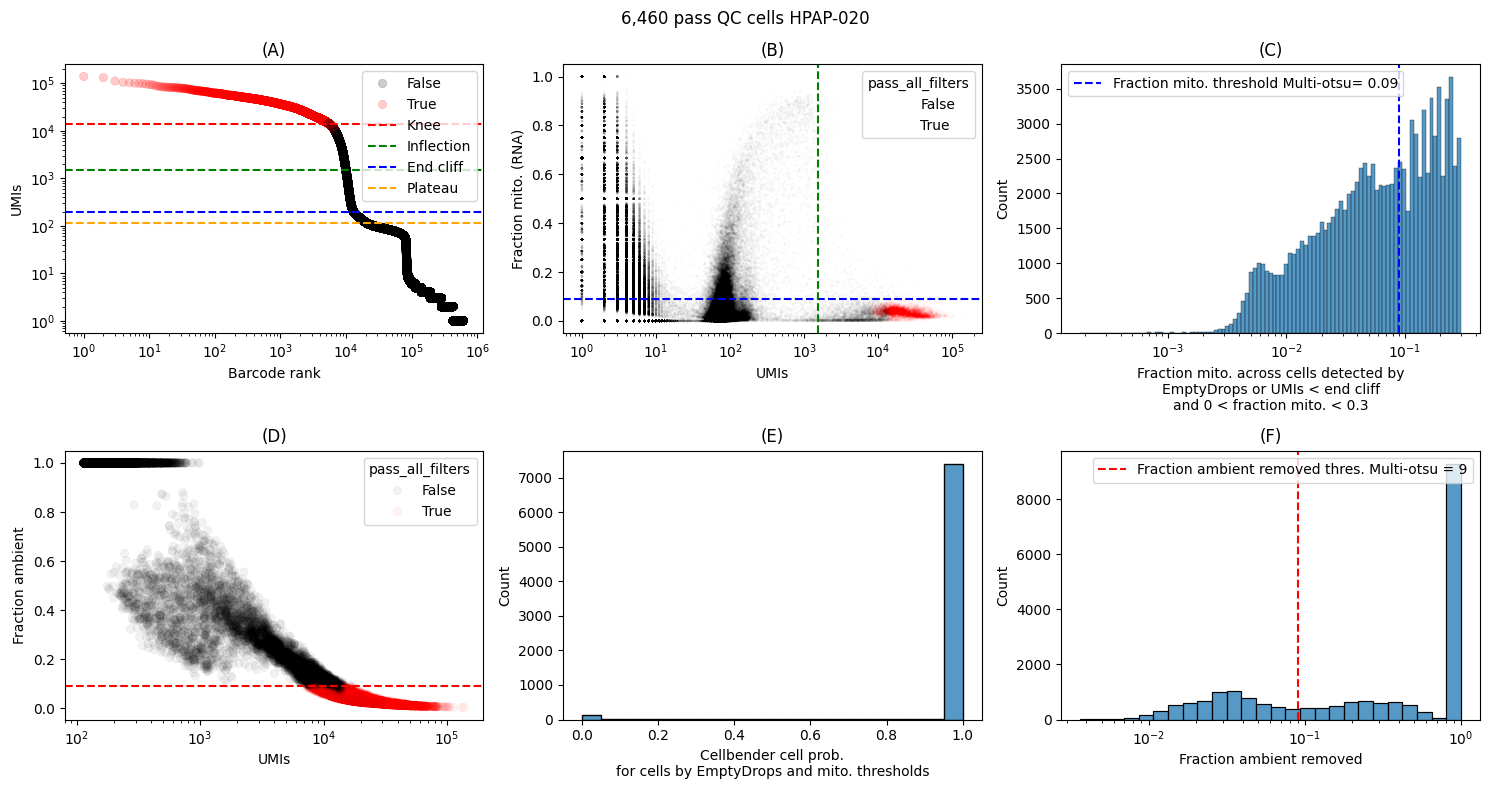

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(5*3, 8))

ax = axs[0, 0]
barcode_rank_plot(metrics, ax)
ax.axhline(knee, color='red', ls='--', label='Knee')
ax.axhline(inflection, color='green', ls='--', label='Inflection')
ax.axhline(endCliff, color='blue', ls='--', label='End cliff')
ax.axhline(plateau, color='orange', ls='--', label='Plateau')
ax.legend()
ax.set_title('(A)')

ax = axs[0, 1]
rna_umis_vs_rna_mito_plot(metrics, ax)
ax.axhline(THRESHOLD_RNA_MAX_MITO/100, color='blue', ls='--')
ax.axvline(inflection, color='green', ls='--')
ax.set_title('(B)')

ax = axs[0, 2] #this plot is subjected to changes when optimizing for %MT thresholds
sns.histplot(x='rna_fraction_mitochondrial', data=metrics[((metrics.rna_umis < endCliff) | (metrics.filter_rna_emptyDrops == True)) & (metrics.mt_pct>0) & (metrics.mt_pct<30)], ax=ax, log_scale=True)
ax.axvline(THRESHOLD_RNA_MAX_MITO/100, color='blue', ls='--', label='Fraction mito. threshold Multi-otsu= {:,}'.format(THRESHOLD_RNA_MAX_MITO/100))
ax.legend()
ax.set_xlabel('Fraction mito. across cells detected by\nEmptyDrops or UMIs < end cliff\nand 0 < fraction mito. < 0.3')
ax.set_title('(C)')

ax = axs[1, 0]
cellbender_fraction_removed(metrics, ax)
ax.axhline(THRESHOLD_FRACTION_CB_REMOVED/100, color='red', ls='--')
ax.set_title('(D)')

ax = axs[1, 1]
cellbender_cell_probabilities(metrics, ax)
ax.set_title('(E)')

ax = axs[1, 2]
sns.histplot(x='fraction_cellbender_removed', data=metrics[(metrics.barcode!='-')], ax=ax, log_scale=True)
ax.axvline(THRESHOLD_FRACTION_CB_REMOVED/100, color='red', ls='--', label='Fraction ambient removed thres. Multi-otsu = {:,}'.format(THRESHOLD_FRACTION_CB_REMOVED))
ax.legend()
ax.set_xlabel('Fraction ambient removed')
ax.set_title('(F)')

fig.suptitle('{:,} pass QC cells'.format(len(pass_qc_cells)) + " " + donor)

plt.tight_layout()
plt.show()

#fig.savefig(args.qcPlot, bbox_inches='tight', dpi=300)

Explanation: <br>
1. Panel (A): Barcode rank plot. Each dot corresponds to a barcode. X-axis is the rank of barcodes based on number of UMIs, y-axis is the number of UMIs. Red dots (labeled "True"): barcodes that satisfy all QC criteria, black dots (labeled "False"): barcodes that do not satisfy all QC criteria. Red dashed line: number of UMIs of the knee point (predicted using EmptyDrops); green dashed line: number of UMIs of the inflection point (detected using EmptyDrops); blue dashed line: number of UMIs of the end of cliff point, which is defined as the point with log-rank higher than that of inflection points (detected using EmptyDrops) and minimizes the signed curvatures; yellow dashed line: number of UMIs of the empty-drop plateau point (detected using CellBender, default settings). <br>
2. Panel (B): Scatterplot showing number of UMIs vs. fraction of mitochondria (mito.) reads. Each dot corresponds to a barcode. X-axis is the number of UMIs, y-axis is fraction of mito. reads. Red dots (labeled "True"): barcodes that satisfy all QC criteria, black dots (labeled "False"): barcodes that do not satisfy all QC criteria. Green dashed line: number of UMIs of the inflection point (detected using EmptyDrops); blue dashed line: threshold for fraction of mito. reads. <br>
3. Panel (C): Histogram showing the distribution of the fraction of mito. reads across two sets of cells: non-empty cells, and cells whose fraction of mito. rates < 0.3 and rank higher than that of cliff end points. Blue dashed line: threshold for percent of chrMT reads. Percent of chrMT reads = fraction of chrMT reads * 100.<br>
4. Panel (D): Scatterplot showing number of UMIs vs. fraction of abient RNA removed. Each dot corresponds to a barcode. X-axis is the number of UMIs, y-axis is fraction of ambient counts. Red dots (labeled "True"): barcodes that satisfy all QC criteria, black dots (labeled "False"): barcodes that do not satisfy all QC criteria. Red dashed line: threshold for fraction of removed ambient counts in cells. <br>
5. Panel (E): Histogram showing the distribution of the cell probability (predicted using CellBender, default settings) for cells that satisfy criteria for EmptyDrops and fraction of mito. reads. <br>
5. Panel (F): Histogram showing the distribution of the percent of removed ambient counts across cells that satisfy EmptyDrops criterion. Red dashed line: threshold for fraction of removed ambient counts in cells. <br>

/home/vthihong/jointMultiomes/lib/python3.9/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/vthihong/jointMultiomes/lib/python3.9/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

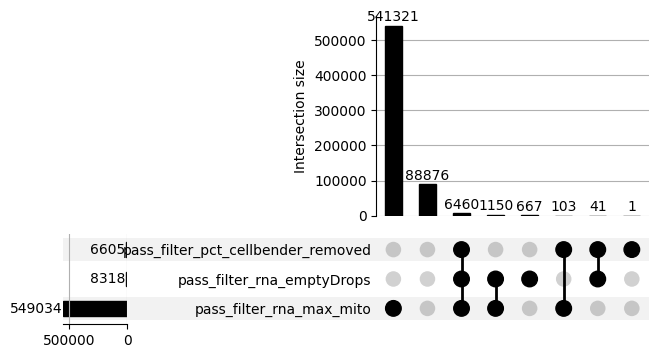

In [31]:
# Plot the number of nuclei passing each filter
fig, ax = plt.subplots(figsize=(7, 6))
ax.remove()

for_upset = metrics.filter(like='filter_').rename(columns=lambda x: 'pass_' + x)
for_upset = for_upset.groupby(for_upset.columns.to_list()).size()
upsetplot.plot(for_upset, fig=fig, sort_by='cardinality', show_counts=True)

## Set up Snakemake file to run for all samples

We can put all the code above into a Python script and run for all samples. An example script is in `scripts/rnaQC_wCellBender.py`.

Of note, the `rnaQC_wCellBender.py` script assumes a file `/nfs/turbo/umms-scjp-pank/4_integration/data/202503_freeze/20250314_meta_runs.txt` which contains some basic metadata. It can look like this:

```
head /nfs/turbo/umms-scjp-pank/4_integration/data/202503_freeze/20250314_meta_runs.txt
study	srr	rrid	treatments	chemistry	sex	age	bmi	diabetes_status_description	source	ethnicity	aab_gada	aab_ia_2	aab_iaa	aab_znt8
GSE142465	SRR10751487	SAMN08611143	Artemether_10muM_72Hr	V2	Male	32	26.2	NonDiabetic	IIDP	na	na	na	na	na
GSE142465	SRR10751488	SAMN08611143	Artemether_Sigma_10muM_72Hr	V2	Male	32	26.2	NonDiabetic	IIDP	na	na	na	na	na
GSE142465	SRR10751489	SAMN08611143	DMSO_Control_72Hr	V2	Male	32	26.2	NonDiabetic	IIDP	na	na	na	na	na
```

If the metadata file is different, the code has to be changed accordingly.

One can set up a Snakefile like one in `scrippts/Snakefile_QCplots` in order to run for every sample.

Dependencies for the environment to create these plots are in file `python_req.yml`.